<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Pytorch_Workout_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning**

In [1]:
!pip3 install torch torchvision

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import requests as req
import PIL as pil

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

**Loading Data**

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 44.77 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
img_size = 224, 224
normalization = .5, .5, .5

transform_train = tv.transforms.Compose([
  tv.transforms.Resize(img_size),
  tv.transforms.RandomHorizontalFlip(),
  tv.transforms.ColorJitter(brightness = .1, contrast = .1, saturation = .1, hue = .1),
  tv.transforms.RandomAffine(degrees = 0, shear = 10, scale = (.8, 1.2)),  
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(normalization, normalization)    
])

transform_valid = tv.transforms.Compose([
  tv.transforms.Resize(img_size),
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(normalization, normalization)        
])

dataset_train = tv.datasets.ImageFolder('/content/ants_and_bees/train', transform = transform_train)
dataset_valid = tv.datasets.ImageFolder('/content/ants_and_bees/val', transform = transform_valid)

loader_train = t.utils.data.DataLoader(dataset_train, batch_size = 20, shuffle = True)
loader_valid = t.utils.data.DataLoader(dataset_valid, batch_size = 20, shuffle = False)

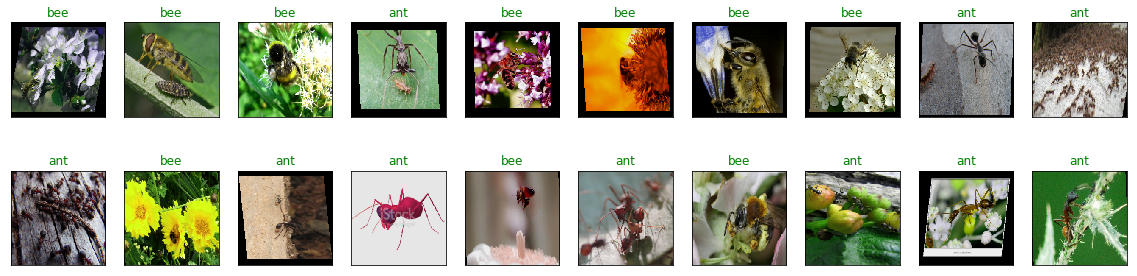

In [6]:
imgs, labels = next(iter(loader_train))

def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  x = x * np.array(normalization) + np.array(normalization)
  plt.title('bee' if pred else 'ant', color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(len(imgs)):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])
    
plot_predictions(imgs, labels, labels)

**Define Model**

In [7]:
model = tv.models.vgg16(pretrained = True)
out_layer = model.classifier[6]
model.classifier[6] = t.nn.Linear(out_layer.in_features, 1)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 83154819.31it/s]


**Train**

In [0]:
def accuracy(y, y_pred):
  y_pred = y_pred > 0
  y_pred = y_pred.float()
  result = t.sum(y == y_pred).item()
  return result / len(y)

In [0]:
def transform_data(x, y):
  return x.cuda(), y.float().view(-1, 1).cuda() 

In [10]:
epochs = 3
optimizer = t.optim.Adam(model.parameters(), lr = 1e-5)
loss_fn = t.nn.BCEWithLogitsLoss()
losses_train, losses_valid, accuracies_train, accuracies_valid = [], [], [], []

for i in range(epochs):
  model.train()
  for x, y in loader_train:
    x, y = transform_data(x, y)
    y_pred = model.forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_train.append(to_numpy(loss))
    accuracies_train.append(accuracy(y, y_pred))    
  model.eval()
  accuracy_epoch = 0
  loss_epoch = 0
  for x, y in loader_valid:
    x, y = transform_data(x, y)
    with t.no_grad():
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      loss_epoch += to_numpy(loss)
      accuracy_epoch += accuracy(y, y_pred)
  losses_valid.append(loss_epoch / len(loader_valid))
  accuracies_valid.append(accuracy_epoch / len(loader_valid))
  print('Finished epoch', i + 1)

Finished epoch 1
Finished epoch 2
Finished epoch 3


Text(0, 0.5, 'loss')

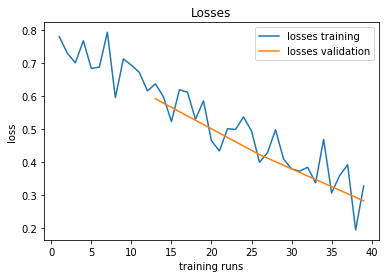

In [11]:
epoch_steps = len(loader_train)
plt.plot(range(1, len(losses_train) + 1), losses_train, label = 'losses training')
plt.plot(range(epoch_steps, len(losses_train) + 1, epoch_steps), losses_valid, label = 'losses validation')
plt.legend()
plt.title('Losses')
plt.xlabel('training runs')
plt.ylabel('loss')

Text(0, 0.5, 'acuracy')

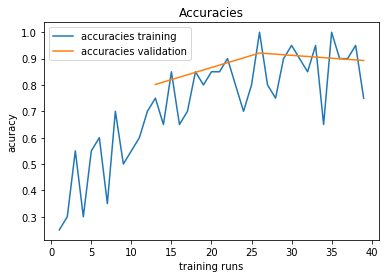

In [12]:
plt.plot(range(1, len(accuracies_train) + 1), accuracies_train, label = 'accuracies training')
plt.plot(range(epoch_steps, len(accuracies_train) + 1, epoch_steps), accuracies_valid, label = 'accuracies validation')
plt.legend()
plt.title('Accuracies')
plt.xlabel('training runs')
plt.ylabel('acuracy')

In [13]:
print('Validation accuracy is', accuracies_valid[-1])

Validation accuracy is 0.8927884615384615


**Make predictions**

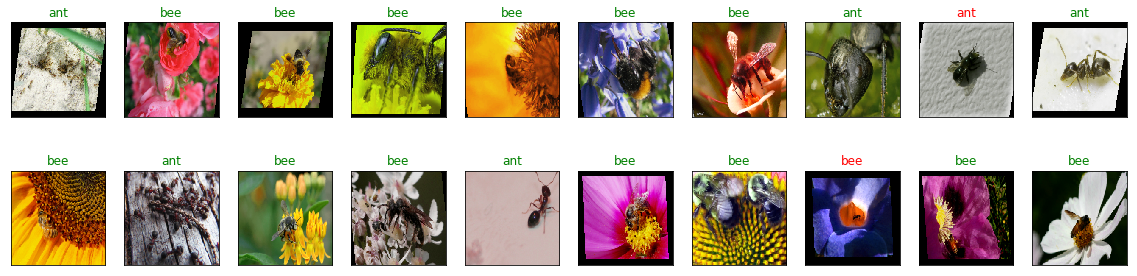

In [14]:
x, y = next(iter(loader_train))
x, y = transform_data(x, y)
y_pred = model(x)
y_pred = y_pred > 0
plot_predictions(x, y, y_pred)

bee


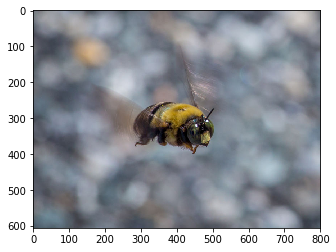

In [32]:
url = 'https://i.kinja-img.com/gawker-media/image/upload/s--4jMLHEnK--/c_scale,f_auto,fl_progressive,q_80,w_800/xdinyzfj69mypp3xvl2d.jpg'
resp = req.get(url, stream = True)
img = pil.Image.open(resp.raw)
plt.imshow(img)
img = transform_valid(img)
img = img.unsqueeze(0)
img = img.cuda()
pred = model.forward(img)
print('bee' if pred[0][0].item() > 0 else 'ant')